  # Compound file processing - Part 2

- Read Plate, Well and compound metdata files
- Create Plate/Well/Compound metadata file consisting of
    - Plate info
    - Well Info
    - Compound info
- Join above file with Compound TPSA file

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%pwd
# %cd Cellpainting/cj-datasets/

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/kevin/WSL-shared/Cellpainting/cj-datasets'

In [12]:
import os
import sys
import argparse
import csv
import json
import time
import types, copy, pprint
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from rdkit import Chem
from rdkit.Chem import PandasTools 
import matplotlib.pyplot as plt

from utils import project_datasets
from KevinsRoutines.utils.utils_chem  import getTPSAFromRDKit, getSmilesFromRDKit
from KevinsRoutines.utils.utils_general import list_namespace

pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
pd.options.display.width = 132

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# time.strftime(' %x%X')
# datetime.now().strftime('%X.%f')
# time.strftime('%X %x %Z')
print(datetime.now().strftime('%D-%X.%f'))
print(datetime.now().strftime('%Y-%M-%d %H:%m:%S.%f'))

['../..', './src', '/home/kevin/WSL-shared/Cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']
06/18/24-11:17:06.442924
2024-17-18 11:06:06.443175


In [19]:
# plates = pd.read_csv(os.path.join(metadata_path,"plate_new.csv"))
# wells = pd.read_csv(os.path.join(metadata_path,"well.csv"))
# compound = pd.read_csv(os.path.join(metadata_path,"compound.csv"))
# orf = pd.read_csv(os.path.join(metadata_path,"orf.csv"))
# crispr = pd.read_csv(os.path.join(metadata_path,"crispr.csv"))
## gz, bz2, zip, tar, tar.gz, tar.bz2
# types = ['.gz', '.bz2','.zip', '.tar', '.tar.gz', '.tar.bz2']
# type_bz2 = 'bz2'
# type_gzip = 'gz'

metadata_path = "./metadata_20240618/"
input_path ="./metadata/"
output_path ="./output_11102023/"
ds = project_datasets(metadata_path=metadata_path, input_path=input_path, output_path=output_path) 

In [20]:
 
print(f" prefix                                   : {ds.prefix} \n" )
print(f" compound Metadata Input File             : {ds.compoundMetadata}")
print(f" plate Metadata Input File                : {ds.plateMetadata}")
print(f" well Metadata Input File                 : {ds.wellMetadata}")
print(f" ORF Metadata File                        : {ds.ORFMetadata}")
print(f" Crispr Metadata File                     : {ds.CrisprMetadata}")
print(f" ")
print(f" compound Metadata Output File            : {ds.compoundMetadataCleanFile}")
print(f" ")
print(f" compound Metadata + TPSA File            : {ds.compoundMetadataTPSAFile}")
print(f" compound Metadata + TPSA Cleaned File    : {ds.compoundMetadataTPSACleanFile}")
print(f" ")
print(f" CompoundExtendedMetadataFile             : {ds.CompoundExtendedMetadataFile }")
print(f" CompoundExtendedMetadataMoreThan3        : {ds.CompoundExtendedMetadataMoreThan3File}")
print()
print(f" CompoundExtendedMetadata 5 SampleFile    : {ds.CompoundExtendedMetadata5SampleFile }")
print(f" CompoundExtendedMetadata 4 SampleFile    : {ds.CompoundExtendedMetadata4SampleFile }")
print(f" CompoundExtendedMetadata 3 SampleFile    : {ds.CompoundExtendedMetadata3SampleFile }")
print(f" CompoundExtendedMetadata 2 SampleFile    : {ds.CompoundExtendedMetadata2SampleFile }")
print(f" ")
print(f" compound TPSA File                       : {ds.compoundTPSAFile}")
print(f" compound TPSA Clean File                 : {ds.compoundTPSACleanFile}\n")

# print(f" compound Pharmacophore Sparse File       : {compoundPharmacophoreFile}")
# print(f" compound Pharmacophore Sparse Clean File : {compoundPharmacophoreCleanFile}\n")
# print(f" compound Pharmacophore Dense File        : {compoundPharmacophoreDenseFile}")
# print(f" compound Pharmacophore Dense Zipped File : {compoundPharmacophoreDenseZipFile}")

 prefix                                   :  

 compound Metadata Input File             : ./metadata_20240618/compound.csv
 plate Metadata Input File                : ./metadata_20240618/plate_new.csv
 well Metadata Input File                 : ./metadata_20240618/well.csv
 ORF Metadata File                        : ./metadata_20240618/orf.csv
 Crispr Metadata File                     : ./metadata_20240618/crispr.csv
 
 compound Metadata Output File            : ./output_11102023/compound_metadata_clean.csv
 
 compound Metadata + TPSA File            : ./output_11102023/compound_metadata_tpsa.csv
 compound Metadata + TPSA Cleaned File    : ./output_11102023/compound_metadata_tpsa_clean.csv
 
 CompoundExtendedMetadataFile             : ./output_11102023/compound_extended_metadata.csv
 CompoundExtendedMetadataMoreThan3        : ./output_11102023/compound_extended_metadata_morethan_3_wells.csv

 CompoundExtendedMetadata 5 SampleFile    : ./output_11102023/compound_extended_metadata_5samp

In [7]:
# compounds   = pd.read_csv(ds.compoundMetadata)
# wells    = pd.read_csv(ds.plateMetadata)
# compound = pd.read_csv(ds.wellMetadata)
# orf      = pd.read_csv(ds.ORFMetadata)
# crispr   = pd.read_csv(ds.CrisprMetadata)

# Read Metadata files

## compound_metadata_tpsa clean file

 ##### Number of compounds: 116,691 
 (There are: 
   -  116,753 Unique compounds on the Compounds metadata file provided by broad
   -  116,691 Compounds in the Compound/TPSA file we have created. 
   -  138,907 unique compounds with JCP2022 codes on the Wells metadata file - 23216 compounds are missing

In [10]:
print(f"compound+Metadata+TPSA Clean File  {ds.compoundMetadataTPSACleanFile}")

compound+Metadata+TPSA Clean File  ./output_11102023/compound_metadata_tpsa_clean.csv


In [11]:
# df = pd.read_csv('JUMP-MOA_compound_metadata.tsv', delimiter='\t')
# df = pd.read_csv('JUMP-Target-1_compound_metadata.tsv', delimiter='\t')
# df = pd.read_csv(compoundMetadataOutputFile)
# df = pd.read_csv(compoundMetadataOutputFile_2)
# inputFile1 = compoundMetadataTPSAFile

 
df_compounds = pd.read_csv(ds.compoundMetadataTPSACleanFile)
df_compounds.info()
df_compounds.head(2)
df_compounds.tail(2)

# df_compounds[df_compounds.Metadata_JCP2022 == "JCP2022_UNKNOWN"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_JCP2022     116691 non-null  object 
 1   Metadata_Hash        116691 non-null  int64  
 2   Metadata_Bin         116691 non-null  int64  
 3   Metadata_InChIKey    116691 non-null  object 
 4   Metadata_InChI       116691 non-null  object 
 5   Metadata_Smiles      116691 non-null  object 
 6   Metadata_TPSA        116691 non-null  float64
 7   Metadata_lnTPSA      116691 non-null  float64
 8   Metadata_logTPSA     116691 non-null  float64
 9   Metadata_Permiation  116691 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 8.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
0,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
1,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
116689,JCP2022_116752,8043583690001075349,9,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
116690,JCP2022_116753,-9112886486787329276,4,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


## Compound Metadata

In [21]:
print(f"Compound Metadata file:  {ds.compoundMetadata}")
df_compounds = pd.read_csv(ds.compoundMetadata)

Compound Metadata file:  ./metadata_20240618/compound.csv


In [14]:
print(df_compounds.info())
df_compounds.head(3)
df_compounds.tail(3)
len(df_compounds['Metadata_JCP2022'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116753 entries, 0 to 116752
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116753 non-null  object
 1   Metadata_InChIKey  116752 non-null  object
 2   Metadata_InChI     116752 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB
None


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...
116752,JCP2022_999999,NaN,NaN


116753

In [23]:
# print(df_compounds.info())
# df_compounds.head(3)
# df_compounds.tail(3)
# len(df_compounds['Metadata_JCP2022'].unique())

## Plate Metadata

In [26]:
# ds.plateMetadata = './metadata_20240618/plate.csv'
print(f"Plate file:  {ds.plateMetadata}")
df_plate = pd.read_csv(ds.plateMetadata)

Plate file:  ./metadata_20240618/plate.csv


In [16]:
print(df_plate.info())
df_plate.head(3)
df_plate.tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2378 entries, 0 to 2377
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     2378 non-null   object
 1   Metadata_Batch      2378 non-null   object
 2   Metadata_Plate      2378 non-null   object
 3   Metadata_PlateType  2378 non-null   object
dtypes: object(4)
memory usage: 74.4+ KB
None


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
0,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY
1,source_1,Batch1_20221004,UL001641,COMPOUND
2,source_1,Batch1_20221004,UL001643,COMPOUND


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
2375,source_9,20211103-Run16,GR00004419,COMPOUND
2376,source_9,20211103-Run16,GR00004420,COMPOUND
2377,source_9,20211103-Run16,GR00004421,COMPOUND


In [17]:
df_plate.Metadata_PlateType.value_counts()
df_plate.Metadata_Source.value_counts()
# df[df['Metadata_JCP2022'].isna()]

Metadata_PlateType
COMPOUND          1729
ORF                251
CRISPR             148
TARGET2            141
DMSO                77
COMPOUND_EMPTY      20
POSCON8              8
TARGET1              4
Name: count, dtype: int64

Metadata_Source
source_3     303
source_4     277
source_5     260
source_6     246
source_2     229
source_10    222
source_8     216
source_11    180
source_13    154
source_7     128
source_9     108
source_1      55
Name: count, dtype: int64

In [67]:
df_plate.Metadata_PlateType.value_counts()
df_plate.Metadata_Source.value_counts()
df_plate[['Metadata_Source', 'Metadata_PlateType']].value_counts()

Metadata_PlateType
COMPOUND          1729
ORF                251
CRISPR             148
TARGET2            141
DMSO                77
COMPOUND_EMPTY      20
POSCON8              8
TARGET1              4
Name: count, dtype: int64

Metadata_Source
source_3     303
source_4     277
source_5     260
source_6     246
source_2     229
source_10    222
source_8     216
source_11    180
source_13    154
source_7     128
source_9     108
source_1      55
Name: count, dtype: int64

Metadata_Source  Metadata_PlateType
source_4         ORF                   251
source_3         COMPOUND              237
source_6         COMPOUND              225
source_2         COMPOUND              219
source_10        COMPOUND              208
source_8         COMPOUND              199
source_5         COMPOUND              197
source_11        COMPOUND              173
source_13        CRISPR                148
source_7         COMPOUND              121
source_9         COMPOUND               99
source_1         COMPOUND               51
source_3         DMSO                   38
source_5         DMSO                   31
source_3         TARGET2                25
source_5         TARGET2                24
source_4         TARGET2                22
source_6         TARGET2                21
source_8         COMPOUND_EMPTY         13
source_2         TARGET2                10
source_9         TARGET2                 9
source_5         POSCON8                 8
source_10        D

## Well Metadata

In [29]:
print(f"Well file: {ds.wellMetadata}")
df_wells = pd.read_csv(ds.wellMetadata)

Well file: ./metadata_20240618/well.csv


In [49]:
print(df_wells.info())
df_wells.head(2)
df_wells.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096074 entries, 0 to 1096073
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Metadata_Source   1096074 non-null  object
 1   Metadata_Plate    1096074 non-null  object
 2   Metadata_Well     1096074 non-null  object
 3   Metadata_JCP2022  1096074 non-null  object
dtypes: object(4)
memory usage: 33.4+ MB
None


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
0,source_1,UL000081,A02,JCP2022_033924
1,source_1,UL000081,A03,JCP2022_085227


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
1096072,source_9,GR00004421,Z47,JCP2022_033924
1096073,source_9,GR00004421,Z48,JCP2022_037716


In [30]:
print(df_wells.info())
df_wells.head(2)
df_wells.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096069 entries, 0 to 1096068
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Metadata_Source   1096069 non-null  object
 1   Metadata_Plate    1096069 non-null  object
 2   Metadata_Well     1096069 non-null  object
 3   Metadata_JCP2022  1096069 non-null  object
dtypes: object(4)
memory usage: 33.4+ MB
None


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
0,source_1,UL000081,A02,JCP2022_033924
1,source_1,UL000081,A03,JCP2022_085227


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
1096067,source_9,GR00004421,Z47,JCP2022_033924
1096068,source_9,GR00004421,Z48,JCP2022_037716


In [110]:
df_well_pert = df_wells['Metadata_JCP2022']
df_well_compound_rows = df_well_pert[df_well_pert.lt('JCP2022_200000')]
df_well_crispr_rows = df_well_pert[df_well_pert.between('JCP2022_799999', 'JCP2022_900000')]
df_well_orf_rows = df_well_pert[df_well_pert.between('JCP2022_899999', 'JCP2022_999999')]
ttl_pert_rows = df_well_pert.shape[0]
ttl_compound_rows = df_well_compound_rows.shape[0]
ttl_orf_rows = df_well_crispr_rows.shape[0]
ttl_crispr_rows = df_well_orf_rows.shape[0]

print(f" Number of unqiue sources               ::  {len(df_wells['Metadata_Source'].unique())}")
print()
print(f" Number of total / unique Perturbations         :{ttl_pert_rows:10,d} /  {len(df_wells['Metadata_JCP2022'].unique()):8,d}")
print(f" Number of total / unique Compounds             :{ttl_compound_rows:10,d} /  {len(df_well_compound_rows.unique()):8,d}")
print(f" Number of total / unique ORFs                  :{ttl_orf_rows:10,d} /  {len(df_well_orf_rows.unique()):8,d}")
print(f" Number of total / unique CRISPRs               :{ttl_crispr_rows:10,d} /  {len(df_well_crispr_rows.unique()):8,d}")
print()

 Number of unqiue sources               ::  12

 Number of total / unique Perturbations         : 1,096,074 /   138,907
 Number of total / unique Compounds             :   908,515 /   115,796
 Number of total / unique ORFs                  :    51,192 /    15,133
 Number of total / unique CRISPRs               :   123,793 /     7,977



In [82]:
df_well_pert = df_wells['Metadata_JCP2022']
df_well_compound_rows = df_well_pert[df_well_pert.lt('JCP2022_200000')]
df_well_crispr_rows = df_well_pert[df_well_pert.between('JCP2022_799999', 'JCP2022_900000')]
df_well_orf_rows = df_well_pert[df_well_pert.between('JCP2022_899999', 'JCP2022_999999')]
df_well_misc_rows = df_well_pert[df_well_pert.gt('JCP2022_999999')]
ttl_pert_rows = df_well_pert.shape[0]
ttl_compound_rows = df_well_compound_rows.shape[0]
ttl_orf_rows = df_well_crispr_rows.shape[0]
ttl_crispr_rows = df_well_orf_rows.shape[0]
ttl_misc_rows = df_well_misc_rows.shape[0]

print(f" Number of unqiue sources               ::  {len(df_wells['Metadata_Source'].unique())}")
print()
print(f" Number of total / unique Compounds             :{ttl_compound_rows:10,d} /  {len(df_well_compound_rows.unique()):8,d}")
print(f" Number of total / unique ORFs                  :{ttl_orf_rows:10,d} /  {len(df_well_orf_rows.unique()):8,d}")
print(f" Number of total / unique CRISPRs               :{ttl_crispr_rows:10,d} /  {len(df_well_crispr_rows.unique()):8,d}")
print(f" Number of total / unique misc JCP2022s         :{ttl_misc_rows:10,d} /  {len(df_well_misc_rows.unique()):8,d}")
print()
print(f"                            Totals              :{ttl_pert_rows:10,d} /  {len(df_wells['Metadata_JCP2022'].unique()):8,d}")

 Number of unqiue sources               ::  12

 Number of total / unique Compounds             :   908,510 /   115,795
 Number of total / unique ORFs                  :    51,192 /    15,133
 Number of total / unique CRISPRs               :   123,793 /     7,977
 Number of total / unique misc JCP2022s         :    12,574 /         1

                            Totals              : 1,096,069 /   138,906


In [85]:
df_source_well_counts = df_wells.Metadata_Source.value_counts()
df_source_plate_counts = df_plate.Metadata_Source.value_counts()
df_join = pd.merge(df_source_plate_counts, df_source_well_counts, on ="Metadata_Source")
df_join['well_per_plate'] = df_join.count_y / df_join.count_x
print(f" -----------------------")
print(f" Well counts by Source")
print(f" -----------------------")
print(df_join.sort_index())
print(f" total number of populted wells : {df_compound_counts.sum()}")

 -----------------------
 Well counts by Source
 -----------------------
                 count_x  count_y  well_per_plate
Metadata_Source                                  
source_1              55    80613     1465.690909
source_10            222    85235      383.941441
source_11            180    68347      379.705556
source_13            154    59136      384.000000
source_2             229    87860      383.668122
source_3             303   116271      383.732673
source_4             277   106352      383.942238
source_5             260    99836      383.984615
source_6             246    94459      383.979675
source_7             128    49143      383.929688
source_8             216    82929      383.930556
source_9             108   165888     1536.000000
 total number of populted wells : 1096069


In [86]:
df_compound_counts = df_wells.Metadata_JCP2022.value_counts()

print(f" -----------------------")
print(f" Well counts by compound")
print(f" -----------------------")
df_compound_counts[:35]
print(f" total number of populted wells : {df_compound_counts.sum()}")

 -----------------------
 Well counts by compound
 -----------------------


Metadata_JCP2022
JCP2022_033924     138936
JCP2022_999999      37094
JCP2022_UNKNOWN     12574
JCP2022_050797       9732
JCP2022_037716       9571
JCP2022_012818       9544
JCP2022_025848       9513
JCP2022_046054       9508
JCP2022_064022       9346
JCP2022_085227       8923
JCP2022_035095       7983
JCP2022_800001       4724
JCP2022_800002       2754
JCP2022_915132       2026
JCP2022_033954       1594
JCP2022_915129        973
JCP2022_915128        973
JCP2022_915131        973
JCP2022_915130        973
JCP2022_900001        632
JCP2022_805264        569
JCP2022_033914        362
JCP2022_013856        361
JCP2022_001036        359
JCP2022_105442        356
JCP2022_080920        355
JCP2022_073628        354
JCP2022_056401        354
JCP2022_032771        354
JCP2022_004587        354
JCP2022_046462        354
JCP2022_060040        353
JCP2022_015955        349
JCP2022_102083        348
JCP2022_001890        344
Name: count, dtype: int64

 total number of populted wells : 1096069


In [60]:
df_compound_counts['JCP2022_999999']

37094

## ORF (Open reading frame) Metadata

**ORF Types:**

trt are ORF treatments, where the cells are perturbed by an ORF treatment.
- **poscon** are four compound treatments that are used as positive control.
- **negcon** are four ORF treatments that are used as negative control. They are not expected to cause morphological changes.

In [24]:
print(f"ORF file:  {ds.ORFMetadata}")
df_orf = pd.read_csv(ds.ORFMetadata)

ORF file:  ./metadata/orf.csv


In [45]:
df_orf.info()
df_orf.head()
df_orf.tail()
print()
df_orf_symbols_unique= pd.DataFrame(df_orf['Metadata_Symbol'].unique(), columns=['Metadata_Symbol'])
print(f" Unique Metadata Symbols {len(df_orf['Metadata_Symbol'].unique())}")
df_orf_symbols_unique.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15142 entries, 0 to 15141
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Metadata_JCP2022           15142 non-null  object 
 1   Metadata_broad_sample      15142 non-null  object 
 2   Metadata_Name              15132 non-null  object 
 3   Metadata_Vector            15142 non-null  object 
 4   Metadata_Transcript        15106 non-null  object 
 5   Metadata_Symbol            15107 non-null  object 
 6   Metadata_NCBI_Gene_ID      15107 non-null  object 
 7   Metadata_Taxon_ID          15107 non-null  object 
 8   Metadata_Gene_Description  14853 non-null  object 
 9   Metadata_Prot_Match        14320 non-null  float64
 10  Metadata_Insert_Length     15141 non-null  float64
 11  Metadata_pert_type         15142 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.4+ MB


,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
1,JCP2022_900003,ccsbBroad304_00002,ORF005388.1_TRC304.1,pLX_304,NM_001088.3,AANAT,15,9606,aralkylamine N-acetyltransferase,100.0,621.0,trt
2,JCP2022_900004,ccsbBroad304_00003,ORF003876.1_TRC304.1,pLX_304,NM_000663.4,ABAT,18,9606,4-aminobutyrate aminotransferase,100.0,1500.0,trt
3,JCP2022_900005,ccsbBroad304_00007,ORF004679.1_TRC304.1,pLX_304,NM_000018.4,ACADVL,37,9606,acyl-CoA dehydrogenase very long chain,100.0,1965.0,trt
4,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,1584.0,trt


,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
15137,JCP2022_915128,ccsbBroad304_99985,ORFC00001.1_TRC304.1,pLX_304,BFP.1,BFP,BFP,CONTROL,Hahn Lab BFP,99.5,717.0,negcon
15138,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon
15139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,1650.0,negcon
15140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,3204.0,negcon
15141,JCP2022_915132,ccsbBroad304_99997,ORFC00005.1_TRC304.1,pLX_304,eGFP.1,eGFP,eGFP,CONTROL,Hahn Lab eGFP,100.0,717.0,poscon



 Unique Metadata Symbols 12610


,Metadata_Symbol
0,NAT1
1,AANAT
2,ABAT
3,ACADVL
4,ASIC1


## CRISPR (clustered regularly interspaced short palindromic repeats) Metadata

**CRISPR Types:**



In [22]:
print(f"Crispr file:  {ds.CrisprMetadata}")
df_crispr = pd.read_csv(ds.CrisprMetadata)

ORF file:  ./metadata/crispr.csv


In [46]:
df_crispr.info()
df_crispr.head()
df_crispr.tail()
print()
df_crispr_symbols_unique = pd.DataFrame(df_crispr['Metadata_Symbol'].unique(), columns=['Metadata_Symbol'])
print(f" Unique Metadata Symbols {len(df_crispr_symbols_unqiue)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7977 entries, 0 to 7976
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Metadata_JCP2022       7977 non-null   object 
 1   Metadata_NCBI_Gene_ID  7975 non-null   float64
 2   Metadata_Symbol        7977 non-null   object 
dtypes: float64(1), object(2)
memory usage: 187.1+ KB


,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol
0,JCP2022_800001,NaN,no-guide
1,JCP2022_800002,NaN,non-targeting
2,JCP2022_800003,2.0,A2M
3,JCP2022_800004,127550.0,A3GALT2
4,JCP2022_800005,53947.0,A4GALT


,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Symbol
7972,JCP2022_807973,54925.0,ZSCAN32
7973,JCP2022_807974,201516.0,ZSCAN4
7974,JCP2022_807975,79149.0,ZSCAN5A
7975,JCP2022_807976,7746.0,ZSCAN9
7976,JCP2022_807977,151112.0,ZSWIM2



 Unique Metadata Symbols 7977


In [44]:
 
df_symbols_join = pd.merge( df_orf_symbols_unique,df_crispr_symbols_unique, how='left', on=['Metadata_Symbol'], indicator = True)
df_symbols_join.shape
df_symbols_join.head()

(12610, 2)

,Metadata_Symbol,_merge
0,NAT1,both
1,AANAT,both
2,ABAT,both
3,ACADVL,both
4,ASIC1,both


## Plate - Well - Compound Analysis

  #### Number of unqiue pertubation types (compounds + ORFs + CRISPRs) ::  138907

In [62]:
# df_compound_plates = df_plate[(df_plate.Metadata_PlateType == 'COMPOUND') & (df_plate.Metadata_Source=='source_3')]
for plateType in ["COMPOUND","ORF","CRISPR","TARGET1","TARGET2","DMSO","COMPOUND_EMPTY","POSCON8"]:
    print("\n "+"-"*50)
    print(f" Plate type: {plateType}")
    print(f" "+"-"*50)    
    df_cmp_plates = df_plate[(df_plate.Metadata_PlateType == plateType) ]

    print(f"   Number of plates for type {plateType} : {df_cmp_plates.shape[0]}")
    # df_cmp_plates.head(5)
    
    print(f"\n   Counts by source sites:")
    print(  f"   -----------------------")
    source_plate_counts = df_cmp_plates.Metadata_Source.value_counts()

    
    for idx, val in source_plate_counts.items():
        print(f"     {idx:15s}        {val:5d}")
    print(f"\n     Total plates:        {source_plate_counts.sum():7d}")
    
    df_join = pd.merge( df_cmp_plates, df_wells, how='left', on=['Metadata_Source','Metadata_Plate'], indicator = True)
    # df_join._merge.value_counts()
    print(f"\n   Total number of wells           : {df_join.shape[0]:7d}")
    unique_cmpds = len(df_join.Metadata_JCP2022.unique())
    print(f"   Total number of unique compounds: {unique_cmpds:7d}")
    
    if unique_cmpds < 20:
        df_vc = df_join.Metadata_JCP2022.value_counts().sort_index()
        print(f"\n     Compound              Wells")
        for idx, val in df_vc.items():
            print(f"     {idx:15s}        {val:5d}")
        print(f"\n     Total wells:        {df_vc.sum():8d}")        
        del df_vc
    del df_cmp_plates, df_join, source_plate_counts, 


 --------------------------------------------------
 Plate type: COMPOUND
 --------------------------------------------------
   Number of plates for type COMPOUND : 1729

   Counts by source sites:
   -----------------------
     source_3                 237
     source_6                 225
     source_2                 219
     source_10                208
     source_8                 199
     source_5                 197
     source_11                173
     source_7                 121
     source_9                  99
     source_1                  51

     Total plates:           1729

   Total number of wells           :  832290
   Total number of unique compounds:  115732

 --------------------------------------------------
 Plate type: ORF
 --------------------------------------------------
   Number of plates for type ORF : 251

   Counts by source sites:
   -----------------------
     source_4                 251

     Total plates:            251

   Total number of we

# Create `Source/Batch/Plate/Well/Compound`  file

## Extract all plates where PlateType == `COMPOUND`

 #### Total number of plates 1729

In [114]:
df_cmp_plates = df_plate[(df_plate.Metadata_PlateType == 'COMPOUND') ]
df_cmp_plates.info()

source_plate_counts = df_cmp_plates.Metadata_Source.value_counts()
source_plate_counts
source_plate_counts.sum()


<class 'pandas.core.frame.DataFrame'>
Index: 1729 entries, 1 to 2377
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     1729 non-null   object
 1   Metadata_Batch      1729 non-null   object
 2   Metadata_Plate      1729 non-null   object
 3   Metadata_PlateType  1729 non-null   object
dtypes: object(4)
memory usage: 67.5+ KB


Metadata_Source
source_3     237
source_6     225
source_2     219
source_10    208
source_8     199
source_5     197
source_11    173
source_7     121
source_9      99
source_1      51
Name: count, dtype: int64

1729

## Join Plates and Well-Compound information

  **We will lose some compounds that are related to non-compound plates during join**

In [115]:
df_cmp_plates.info()
print('\n\n')
df_wells.info()
print('\n\n')
df_cmp_plates_wells = pd.merge( df_cmp_plates,df_wells, how='left', on=['Metadata_Source','Metadata_Plate'], indicator = True)

df_cmp_plates_wells.info()
df_cmp_plates_wells._merge.value_counts()
print()
len(df_cmp_plates_wells.Metadata_JCP2022.unique())

<class 'pandas.core.frame.DataFrame'>
Index: 1729 entries, 1 to 2377
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     1729 non-null   object
 1   Metadata_Batch      1729 non-null   object
 2   Metadata_Plate      1729 non-null   object
 3   Metadata_PlateType  1729 non-null   object
dtypes: object(4)
memory usage: 67.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096074 entries, 0 to 1096073
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Metadata_Source   1096074 non-null  object
 1   Metadata_Plate    1096074 non-null  object
 2   Metadata_Well     1096074 non-null  object
 3   Metadata_JCP2022  1096074 non-null  object
dtypes: object(4)
memory usage: 33.4+ MB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832295 entries, 0 to 832294
Data columns (total 7 columns):
 #   Column     

_merge
both          832295
left_only          0
right_only         0
Name: count, dtype: int64

115733

In [64]:
df_cmp_plates.info()
print('\n\n')
df_wells.info()
print('\n\n')
df_cmp_plates_wells = pd.merge( df_cmp_plates,df_wells, how='left', on=['Metadata_Source','Metadata_Plate'], indicator = True)

df_cmp_plates_wells.info()
df_cmp_plates_wells._merge.value_counts()
print()
len(df_cmp_plates_wells.Metadata_JCP2022.unique())

<class 'pandas.core.frame.DataFrame'>
Index: 1729 entries, 1 to 2377
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     1729 non-null   object
 1   Metadata_Batch      1729 non-null   object
 2   Metadata_Plate      1729 non-null   object
 3   Metadata_PlateType  1729 non-null   object
dtypes: object(4)
memory usage: 67.5+ KB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096069 entries, 0 to 1096068
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Metadata_Source   1096069 non-null  object
 1   Metadata_Plate    1096069 non-null  object
 2   Metadata_Well     1096069 non-null  object
 3   Metadata_JCP2022  1096069 non-null  object
dtypes: object(4)
memory usage: 33.4+ MB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832290 entries, 0 to 832289
Data columns (total 7 columns):
 #   Column  

_merge
both          832290
left_only          0
right_only         0
Name: count, dtype: int64

115732

In [116]:
source_well_counts = df_cmp_plates_wells.Metadata_Source.value_counts()
source_well_counts 
print("\n ------------------------------------")
print(f" Average wells per plate by source")
print(f" ------------------------------------")
source_well_counts / source_plate_counts

Metadata_Source
source_9     152064
source_3      90929
source_6      86395
source_2      84032
source_10     79862
source_8      76401
source_5      75646
source_1      74843
source_11     65663
source_7      46460
Name: count, dtype: int64


 ------------------------------------
 Average wells per plate by source
 ------------------------------------


Metadata_Source
source_1     1467.509804
source_10     383.951923
source_11     379.554913
source_2      383.707763
source_3      383.666667
source_5      383.989848
source_6      383.977778
source_7      383.966942
source_8      383.924623
source_9     1536.000000
Name: count, dtype: float64

In [83]:
source_well_counts = df_cmp_plates_wells.Metadata_Source.value_counts()
source_well_counts 
print("\n ------------------------------------")
print(f" Average wells per plate by source")
print(f" ------------------------------------")
source_well_counts / source_plate_counts

Metadata_Source
source_9     152064
source_3      90929
source_6      86395
source_2      84032
source_10     79862
source_8      76401
source_5      75646
source_1      74843
source_11     65663
source_7      46455
Name: count, dtype: int64


 ------------------------------------
 Average wells per plate by source
 ------------------------------------


Metadata_Source
source_1     1467.509804
source_10     383.951923
source_11     379.554913
source_2      383.707763
source_3      383.666667
source_5      383.989848
source_6      383.977778
source_7      383.925620
source_8      383.924623
source_9     1536.000000
Name: count, dtype: float64

In [126]:
df_source_well_counts = df_cmp_plates_wells.Metadata_Source.value_counts().sort_index()
df_source_well_counts
df_source_plate_counts = df_cmp_plates_wells[['Metadata_Source','Metadata_Plate']].value_counts()
df_source_plate_counts
df_source_plate_grp= df_source_plate_counts.groupby(['Metadata_Source','Metadata_Plate']).count()
df_source_plate_grp
df_source_plate_grp.groupby('Metadata_Source').sum()
# df_source_plate_grp['Metadata_Source'].value_counts()
# for group in df_source_plate_grp:
#     group[0]
#     group[1]
#     break
# df_source_plate_counts = df_cmp_plates_wells[['Metadata_Source','Metadata_Plate']].count()
df_cmp_plates_wells.head()

Metadata_Source
source_1      74843
source_10     79862
source_11     65663
source_2      84032
source_3      90929
source_5      75646
source_6      86395
source_7      46455
source_8      76401
source_9     152064
Name: count, dtype: int64

Metadata_Source  Metadata_Plate
source_9         GR00004421        1536
                 GR00003315        1536
                 GR00003317        1536
                 GR00003318        1536
                 GR00003330        1536
                                   ... 
source_3         P24P27dW           319
source_11        EC000137           250
                 EC000038           250
                 EC000045           189
                 EC000048           126
Name: count, Length: 1729, dtype: int64

Metadata_Source  Metadata_Plate
source_1         UL000081          1
                 UL000083          1
                 UL000087          1
                 UL000089          1
                 UL000091          1
                                  ..
source_9         GR00004417        1
                 GR00004418        1
                 GR00004419        1
                 GR00004420        1
                 GR00004421        1
Name: count, Length: 1729, dtype: int64

Metadata_Source
source_1      51
source_10    208
source_11    173
source_2     219
source_3     237
source_5     197
source_6     225
source_7     121
source_8     199
source_9      99
Name: count, dtype: int64

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
0,source_1,Batch1_20221004,UL001641,COMPOUND,A02,JCP2022_033924,both
1,source_1,Batch1_20221004,UL001641,COMPOUND,A03,JCP2022_085227,both
2,source_1,Batch1_20221004,UL001641,COMPOUND,A04,JCP2022_033924,both
3,source_1,Batch1_20221004,UL001641,COMPOUND,A05,JCP2022_036592,both
4,source_1,Batch1_20221004,UL001641,COMPOUND,A06,JCP2022_071885,both


In [127]:
# df_join = pd.merge(df_source_plate_counts, df_source_well_counts, on ="Metadata_Source")
# df_join['well_per_plate'] = df_join.count_y / df_join.count_x
# print(f" -----------------------")
# print(f" Well counts by Source")
# print(f" -----------------------")
# print(df_join.sort_index())
# print(f" total number of populted wells : {df_compound_counts.sum()}")

In [133]:
# df_compound_plates = df_plate[(df_plate.Metadata_PlateType == 'COMPOUND') & (df_plate.Metadata_Source=='source_3')]
for compound in ["JCP2022_012818","JCP2022_025848","JCP2022_033924",
                 "JCP2022_033954","JCP2022_035095","JCP2022_037716","JCP2022_046054",
                 "JCP2022_050797","JCP2022_064022","JCP2022_085227","JCP2022_999999"]:
    
    print("\n "+"-"*50)
    print(f" Compound Id: {compound}")
    print(f" "+"-"*50)    
    df_sel_cmp = df_cmp_plates_wells[(df_cmp_plates_wells.Metadata_JCP2022 ==compound) ]

    print(f"   Number of wells for compound {compound} : {df_sel_cmp.shape[0]}")
    # df_cmp_plates.head(5)
    
    print(f"\n   Counts by source sites:")
    print(  f"   -----------------------")
    source_plate_counts = df_sel_cmp.Metadata_Source.value_counts().sort_index()
    for idx, val in source_plate_counts.items():
        print(f"     {idx:15s}        {val:5d}")
        
    print(f"\n     Total plates:        {source_plate_counts.sum():7d}")
    
    # df_join = pd.merge( df_cmp_plates, df_wells, how='left', on=['Metadata_Source','Metadata_Plate'], indicator = True)
    # # df_join._merge.value_counts()
    # print(f"\n   Total number of wells           : {df_join.shape[0]:7d}")
    # unique_cmpds = len(df_join.Metadata_JCP2022.unique())
    # print(f"   Total number of unique compounds: {unique_cmpds:7d}")
    
    # if unique_cmpds < 20:
    #     df_vc = df_join.Metadata_JCP2022.value_counts().sort_index()
    #     print(f"\n     Compound              Wells")
    #     for idx, val in df_vc.items():
    #         print(f"     {idx:15s}        {val:5d}")
    #     print(f"\n     Total wells:        {df_vc.sum():8d}")        
    #     del df_vc
    # del df_cmp_plates, df_join, source_plate_counts, 


 --------------------------------------------------
 Compound Id: JCP2022_012818
 --------------------------------------------------
   Number of wells for compound JCP2022_012818 : 8111

   Counts by source sites:
   -----------------------
     source_1                 408
     source_10                827
     source_11                648
     source_2                 832
     source_3                 946
     source_5                 788
     source_6                 837
     source_7                 460
     source_8                 781
     source_9                1584

     Total plates:           8111

 --------------------------------------------------
 Compound Id: JCP2022_025848
 --------------------------------------------------
   Number of wells for compound JCP2022_025848 : 8127

   Counts by source sites:
   -----------------------
     source_1                 407
     source_10                832
     source_11                660
     source_2                 832
   

In [141]:
# df_compound_plates = df_plate[(df_plate.Metadata_PlateType == 'COMPOUND') & (df_plate.Metadata_Source=='source_3')]
for compound in ["JCP2022_033924"]:
    
    print("\n "+"-"*50)
    print(f" Compound Id: {compound}")
    print(f" "+"-"*50)    
    df_sel_cmp = df_cmp_plates_wells.query("Metadata_JCP2022 == @compound")
    

    print(f"   Number of wells for compound {compound} : {df_sel_cmp.shape[0]}")
    # df_cmp_plates.head(5)
    
    print(f"\n   Counts by source sites:")
    print(  f"   -----------------------")
    # source_plate_counts = df_sel_cmp.Metadata_Source.value_counts().sort_index()
    source_plate_counts = df_sel_cmp.groupby(['Metadata_Source','Metadata_Plate']).count() 
    source_plate_counts
    break
    for idx, val in source_plate_counts.items():
        print(f"     {idx:15s}        {val:5d}")
        
    print(f"\n     Total plates:        {source_plate_counts.sum():7d}")
    


 --------------------------------------------------
 Compound Id: JCP2022_033924
 --------------------------------------------------
   Number of wells for compound JCP2022_033924 : 88583

   Counts by source sites:
   -----------------------


Metadata_Batch  Metadata_PlateType  Metadata_Well  Metadata_JCP2022  _merge
Metadata_Source Metadata_Plate                                                                             
source_1        UL000081                   129                 129            129               129     129
                UL000083                   117                 117            117               117     117
                UL000087                   128                 128            128               128     128
                UL000089                   713                 713            713               713     713
                UL000091                   129                 129            129               129     129
...                                        ...                 ...            ...               ...     ...
source_9        GR00004417                 128                 128            128               128     128
                GR00004418                 128                 128            128               128     128
                GR00004419                 128                 128            128               128     128
                GR00004420                 128                 128            128               128     128
                GR00004421                 128                 128            128               128     128

[1726 rows x 5 columns]

In [128]:
print(f" Number of unqiue compounds ::  {len(df_cmp_plates_wells['Metadata_JCP2022'].unique())} \n")
df_compound_counts = df_wells.Metadata_JCP2022.value_counts()
df_compound_counts_2 = df_cmp_plates_wells['Metadata_JCP2022'].value_counts()
for i,j in zip(df_compound_counts.index[:35],df_compound_counts_2.index[:35]):
    print(f"   {i:16s}   - {df_compound_counts[i]:7d}        {df_compound_counts_2[j]:7d} -   {j}")

 Number of unqiue compounds ::  115732 

   JCP2022_033924     -  138936          88583 -   JCP2022_033924
   JCP2022_999999     -   37094          25724 -   JCP2022_999999
   JCP2022_UNKNOWN    -   12574          12574 -   JCP2022_UNKNOWN
   JCP2022_050797     -    9732           8138 -   JCP2022_037716
   JCP2022_037716     -    9571           8130 -   JCP2022_064022
   JCP2022_012818     -    9544           8127 -   JCP2022_025848
   JCP2022_025848     -    9513           8127 -   JCP2022_050797
   JCP2022_046054     -    9508           8122 -   JCP2022_046054
   JCP2022_064022     -    9346           8111 -   JCP2022_012818
   JCP2022_085227     -    8923           7707 -   JCP2022_085227
   JCP2022_035095     -    7983           6550 -   JCP2022_035095
   JCP2022_800001     -    4724           1594 -   JCP2022_033954
   JCP2022_800002     -    2754             58 -   JCP2022_101934
   JCP2022_915132     -    2026             49 -   JCP2022_109350
   JCP2022_033954     -    1594   

In [76]:
print(f" Number of unqiue compounds on df_wells ::  {len(df_wells['Metadata_JCP2022'].unique())} ")
print(f" Number of unqiue compounds on df_cmp_plates_wells::  {len(df_cmp_plates_wells['Metadata_JCP2022'].unique())} \n")

df_compound_counts = df_wells.Metadata_JCP2022.value_counts()
df_compound_counts_2 = df_cmp_plates_wells['Metadata_JCP2022'].value_counts()

for i,j in zip(df_compound_counts.index[:35],df_compound_counts_2.index[:35]):
    print(f"   {i:16s}   - {df_compound_counts[i]:7d}        {df_compound_counts_2[j]:7d} -   {j}")

 Number of unqiue compounds on df_wells ::  138906 

 Number of unqiue compounds on df_cmp_plates_wells::  115732 

   JCP2022_033924     -  138936          88583 -   JCP2022_033924
   JCP2022_999999     -   37094          25724 -   JCP2022_999999
   JCP2022_UNKNOWN    -   12574          12574 -   JCP2022_UNKNOWN
   JCP2022_050797     -    9732           8138 -   JCP2022_037716
   JCP2022_037716     -    9571           8130 -   JCP2022_064022
   JCP2022_012818     -    9544           8127 -   JCP2022_025848
   JCP2022_025848     -    9513           8127 -   JCP2022_050797
   JCP2022_046054     -    9508           8122 -   JCP2022_046054
   JCP2022_064022     -    9346           8111 -   JCP2022_012818
   JCP2022_085227     -    8923           7707 -   JCP2022_085227
   JCP2022_035095     -    7983           6550 -   JCP2022_035095
   JCP2022_800001     -    4724           1594 -   JCP2022_033954
   JCP2022_800002     -    2754             58 -   JCP2022_101934
   JCP2022_915132     -  

In [71]:
df_compound_counts.info()
df_compound_counts_2.info()

<class 'pandas.core.series.Series'>
Index: 138906 entries, JCP2022_033924 to JCP2022_803433
Series name: count
Non-Null Count   Dtype
--------------   -----
138906 non-null  int64
dtypes: int64(1)
memory usage: 6.2+ MB
<class 'pandas.core.series.Series'>
Index: 115732 entries, JCP2022_033924 to JCP2022_090832
Series name: count
Non-Null Count   Dtype
--------------   -----
115732 non-null  int64
dtypes: int64(1)
memory usage: 5.8+ MB


In [78]:
df_cmp_count_join = pd.merge(df_compound_counts,df_compound_counts_2, how='outer', indicator= True,left_index=True, right_index=True)

In [81]:
df_cmp_count_join._merge.value_counts()

_merge
both          115732
left_only      23174
right_only         0
Name: count, dtype: int64

## Drop rows with an invalid compound (`JCP2022_999999` or  `JCP2022_UNKNOWN`)

In [119]:
join_999999  = df_cmp_plates_wells[df_cmp_plates_wells.Metadata_JCP2022 == 'JCP2022_999999']
join_999999.head(3)
join_999999_indexes = join_999999.index
join_999999_indexes[:10]

print(f" Number of entires with compound = JCP2022_999999: {len(join_999999_indexes)}")

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
74847,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,COMPOUND,A05,JCP2022_999999,both
74851,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,COMPOUND,A09,JCP2022_999999,both
74855,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,COMPOUND,A13,JCP2022_999999,both


Index([74847, 74851, 74855, 74859, 74863, 74870, 74872, 74874, 74876, 74878], dtype='int64')

 Number of entires with compound = JCP2022_999999: 25724


In [120]:
join_unknown = df_cmp_plates_wells[df_cmp_plates_wells.Metadata_JCP2022 == 'JCP2022_UNKNOWN']
join_unknown.head(3)
join_unknown_indexes = join_unknown.index
join_unknown_indexes[:10]
print(f" Number of entires with compound = JCP2022_UNKNOWN: {len(join_unknown_indexes)}")

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
172602,source_11,Batch2,EC000053,COMPOUND,C12,JCP2022_UNKNOWN,both
172603,source_11,Batch2,EC000053,COMPOUND,C13,JCP2022_UNKNOWN,both
172604,source_11,Batch2,EC000053,COMPOUND,C14,JCP2022_UNKNOWN,both


Index([172602, 172603, 172604, 172605, 172606, 172607, 172608, 172609, 172610, 172611], dtype='int64')

 Number of entires with compound = JCP2022_UNKNOWN: 12574


   ##### JCP2022_033924 == DMSO  - WE DONT DROP THESE

In [121]:
join_033924 = df_cmp_plates_wells[df_cmp_plates_wells.Metadata_JCP2022 == 'JCP2022_033924']
join_033924.head(3)
join_033924_indexes = join_033924.index
join_033924_indexes[:10]
print(f" Number of entires with compound = JCP2022_033924: {len(join_033924_indexes)}")

88583

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
0,source_1,Batch1_20221004,UL001641,COMPOUND,A02,JCP2022_033924,both
2,source_1,Batch1_20221004,UL001641,COMPOUND,A04,JCP2022_033924,both
43,source_1,Batch1_20221004,UL001641,COMPOUND,A45,JCP2022_033924,both


Index([0, 2, 43, 45, 46, 48, 89, 91, 92, 94], dtype='int64')

 Number of entires with compound = JCP2022_033924: 88583


In [123]:
 
all_invalid_indexes = join_999999_indexes.union(join_unknown_indexes)  ##.union(join_033924_indexes)
# joined_invalid_indexes
print(' indexes in join_999999 : ', len(join_999999_indexes)  , '  -- will be dropped')
print(' indexes in join_unknown: ', len(join_unknown_indexes) , '  -- will be dropped')
print('       combinded indexes: ', len(set(join_unknown_indexes) | set(join_999999_indexes)   ) )
print('        indexes in union: ', len(all_invalid_indexes))
print(' indexes in join_033924 : ', len(join_033924_indexes)  , '  -- retained ')


 indexes in join_999999 :  25724   -- will be dropped
 indexes in join_unknown:  12574   -- will be dropped
       combinded indexes:  38298
        indexes in union:  38298
 indexes in join_033924 :  88583   -- retained 


## Drop rows for JCP2022_999999 and JCP2022_UNKNOWN 

 indexes in join_999999 :  25724
 indexes in join_unknown:  12574
 indexes in join_033924 :  88583
       combinded indexes:  38298
        indexes in union:  38298


In [35]:
print(25724 + 12574 + 88583)
print(705414 + 25724 + 12574 + 88583)
print(793997 + 25724 + 12574 )

126881
832295
832295


In [36]:
df_cmp_plates_wells.drop(all_invalid_indexes, inplace = True)
df_cmp_plates_wells.drop(columns=['_merge','Metadata_PlateType'],inplace = True)


In [37]:
df_cmp_plates_wells.info()
df_cmp_plates_wells.head(10)
len(df_cmp_plates_wells.Metadata_JCP2022.unique())


<class 'pandas.core.frame.DataFrame'>
Index: 793997 entries, 0 to 832294
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_Source   793997 non-null  object
 1   Metadata_Batch    793997 non-null  object
 2   Metadata_Plate    793997 non-null  object
 3   Metadata_Well     793997 non-null  object
 4   Metadata_JCP2022  793997 non-null  object
dtypes: object(5)
memory usage: 36.3+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924
1,source_1,Batch1_20221004,UL001641,A03,JCP2022_085227
2,source_1,Batch1_20221004,UL001641,A04,JCP2022_033924
3,source_1,Batch1_20221004,UL001641,A05,JCP2022_036592
4,source_1,Batch1_20221004,UL001641,A06,JCP2022_071885
5,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861
6,source_1,Batch1_20221004,UL001641,A08,JCP2022_078645
7,source_1,Batch1_20221004,UL001641,A09,JCP2022_074163
8,source_1,Batch1_20221004,UL001641,A10,JCP2022_041689
9,source_1,Batch1_20221004,UL001641,A11,JCP2022_098761


115731

# Create Compound Extended Metadata File 

- a file of Plate/Well/Compound/TPSA information

## Join selected Plate/Well Metadata with Compound/TPSA Data

In [38]:
try: 
    del joined_metadata
except Exception as e:
    print('Doesnt exist')

Doesnt exist


In [39]:
df_cmp_plates_wells.info()
print(f" Number of unqiue compounds ::  {len(df_cmp_plates_wells['Metadata_JCP2022'].unique())}")

<class 'pandas.core.frame.DataFrame'>
Index: 793997 entries, 0 to 832294
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_Source   793997 non-null  object
 1   Metadata_Batch    793997 non-null  object
 2   Metadata_Plate    793997 non-null  object
 3   Metadata_Well     793997 non-null  object
 4   Metadata_JCP2022  793997 non-null  object
dtypes: object(5)
memory usage: 36.3+ MB
 Number of unqiue compounds ::  115731


In [40]:
df_compounds.info()
print(f" Number of unqiue compounds ::  {len(df_compounds['Metadata_JCP2022'].unique())}")
# df_compounds.head(2)
# df_compounds.drop(columns='Unnamed: 0',inplace = True)
# df_compounds.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_JCP2022     116691 non-null  object 
 1   Metadata_Hash        116691 non-null  int64  
 2   Metadata_Bin         116691 non-null  int64  
 3   Metadata_InChIKey    116691 non-null  object 
 4   Metadata_InChI       116691 non-null  object 
 5   Metadata_Smiles      116691 non-null  object 
 6   Metadata_TPSA        116691 non-null  float64
 7   Metadata_lnTPSA      116691 non-null  float64
 8   Metadata_logTPSA     116691 non-null  float64
 9   Metadata_Permiation  116691 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 8.9+ MB
 Number of unqiue compounds ::  116691


  ### Join - we will lose some compounds that are not present on the compounds metadata file provided by Broad

In [41]:
# joined_metadata = pd.merge(df_cmp_plates_wells, df_compounds, on=["Metadata_JCP2022]")
# joined_metadata = pd.merge( df_cmp_plates_wells, df_compounds, how='left', on=['Metadata_JCP2022'], indicator = True)
joined_metadata = pd.merge( df_cmp_plates_wells, df_compounds, how='inner', on=['Metadata_JCP2022'], indicator = True)


In [42]:
joined_metadata.info()
joined_metadata.head()
joined_metadata._merge.value_counts()
print(f" Number of unqiue compounds ::  {len(joined_metadata['Metadata_JCP2022'].unique())}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793603 entries, 0 to 793602
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Metadata_Source      793603 non-null  object  
 1   Metadata_Batch       793603 non-null  object  
 2   Metadata_Plate       793603 non-null  object  
 3   Metadata_Well        793603 non-null  object  
 4   Metadata_JCP2022     793603 non-null  object  
 5   Metadata_Hash        793603 non-null  int64   
 6   Metadata_Bin         793603 non-null  int64   
 7   Metadata_InChIKey    793603 non-null  object  
 8   Metadata_InChI       793603 non-null  object  
 9   Metadata_Smiles      793603 non-null  object  
 10  Metadata_TPSA        793603 non-null  float64 
 11  Metadata_lnTPSA      793603 non-null  float64 
 12  Metadata_logTPSA     793603 non-null  float64 
 13  Metadata_Permiation  793603 non-null  int64   
 14  _merge               793603 non-null  category
dtype

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation,_merge
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0,both
1,source_1,Batch1_20221004,UL001641,A03,JCP2022_085227,-418123801347200593,11,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,1,both
2,source_1,Batch1_20221004,UL001641,A04,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0,both
3,source_1,Batch1_20221004,UL001641,A05,JCP2022_036592,-2269427237513215312,8,IPPYTNWGGOIMDZ-UHFFFAOYSA-N,InChI=1S/C17H12ClF3N4O2/c1-24(15-13(18)6-9(7-2...,CN(c1ncc(cc1Cl)C(F)(F)F)N3C=C(C(=N)O)c2ccccc2C3=O,82.21,4.409277,1.914925,0,both
4,source_1,Batch1_20221004,UL001641,A06,JCP2022_071885,497302877741102064,0,PYZMXVUWLLQNEP-UHFFFAOYSA-N,InChI=1S/C10H7ClN4/c11-9-3-1-2-8(4-9)6-15-7-13...,N#CC1=NN=CN1Cc2cccc(Cl)c2,54.50,3.998201,1.736397,0,both


_merge
both          793603
left_only          0
right_only         0
Name: count, dtype: int64

 Number of unqiue compounds ::  115671


In [48]:
joined_metadata.Metadata_Bin.value_counts().sort_index()

Metadata_Bin
0      60095
1      52481
2      53016
3     141937
4      53942
5      63315
6      62152
7      69604
8      53297
9      61113
10     53400
11     69251
Name: count, dtype: int64

In [42]:
# df_compounds.info()
# df_compounds.head()
# df_compounds_indexed = df_compounds.set_index('Metadata_JCP2022')
# df_compounds_indexed.info()
# df_compounds_indexed.head()

In [43]:
# left_only = joined_metadata[joined_metadata._merge == "left_only"]
# left_only.head(10)
# left_only_compounds = left_only.Metadata_JCP2022.value_counts()
# left_only_indexes = left_only_compounds.index
# left_only_compounds
# left_only_indexes

In [44]:
# joined_metadata.reset_index(drop = False)
# df_1 = joined_metadata.set_index('Metadata_JCP2022', drop = False)
# df_1.info()
# df_1.head(3)
# df_1 = df_1.reset_index(drop = True)
# df_1.info()
# df_1.head(3)

## Plot Compound Well counts

In [49]:
df_compound_counts.info()
df_compound_counts.head(10)

<class 'pandas.core.series.Series'>
Index: 138907 entries, JCP2022_033924 to JCP2022_803433
Series name: count
Non-Null Count   Dtype
--------------   -----
138907 non-null  int64
dtypes: int64(1)
memory usage: 6.2+ MB


Metadata_JCP2022
JCP2022_033924     138936
JCP2022_999999      37094
JCP2022_UNKNOWN     12574
JCP2022_050797       9732
JCP2022_037716       9571
JCP2022_012818       9544
JCP2022_025848       9513
JCP2022_046054       9508
JCP2022_064022       9346
JCP2022_085227       8923
Name: count, dtype: int64

In [50]:
 df_compound_counts.min(), df_compound_counts.max(), df_compound_counts.mean() , df_compound_counts.median(), df_compound_counts.std()

(1, 138936, 7.890703852217671, 5.0, 394.1025852129889)

In [51]:
df_compound_counts.head(10)

Metadata_JCP2022
JCP2022_033924     138936
JCP2022_999999      37094
JCP2022_UNKNOWN     12574
JCP2022_050797       9732
JCP2022_037716       9571
JCP2022_012818       9544
JCP2022_025848       9513
JCP2022_046054       9508
JCP2022_064022       9346
JCP2022_085227       8923
Name: count, dtype: int64

In [52]:
df_well_use_counts = df_compound_counts.value_counts()
df_well_use_counts.info()
print('# of Wells used     Compound Count')
df_well_use_counts[:20]
df_well_use_counts.sort_index(inplace=True)
df_well_use_counts[:10]

<class 'pandas.core.series.Series'>
Index: 102 entries, 5 to 138936
Series name: count
Non-Null Count  Dtype
--------------  -----
102 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB
# of Wells used     Compound Count


count
5      52505
4      41342
7      18987
8       9503
6       5899
10      3287
3       2877
9       1996
12       768
15       283
11       267
17       164
2        160
14       134
16        75
13        64
20        62
172       55
182       54
177       45
Name: count, dtype: int64

count
1         4
2       160
3      2877
4     41342
5     52505
6      5899
7     18987
8      9503
9      1996
10     3287
Name: count, dtype: int64

In [49]:
# len(df_well_use_counts.index), len(df_well_use_counts.values)
# df_well_use_counts.sort_values()[:20]
 

In [1]:
# the histogram of the data
_= plt.figure(figsize=(20, 5))
_= plt.bar(df_well_use_counts.index, df_well_use_counts.values, tick_label=df_well_use_counts.index, width = 0.4 ) 
##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
_= plt.xlabel('# of Wells')
_= plt.ylabel('# of Compounds')
_= plt.title('# Wells used by compounds')
_= plt.text(0.1, 10500, r'example $\mu=100,\ \sigma=15$')
_= plt.xlim(0, 30)
_= plt.ylim(0, 10000)
_= plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

In [187]:
# import matplotlib.pyplot as plt
# # the histogram of the data
# plt.figure(figsize=(20, 5))
# # _ = plt.bar(np.log(df_well_use_counts.index), df_well_use_counts.values, tick_label = labels, width = 0.1,log = False) ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
# _ = plt.bar(df_well_use_counts.index, df_well_use_counts.values,  width = 0.1 ) ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
# plt.xlabel('# of Wells');
# plt.ylabel('# of Compounds')
# plt.title('# Wells used by compounds')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# # plt.xlim(0, 60)
# # plt.ylim(0, 1000)
# plt.grid(True)
# plt.show()

### Histogram

In [120]:
# df_compound_counts
# df_well_use_counts?

## Check if any rows have a TPSA of 0.0 or Nan

In [53]:
joined_md_zero = joined_metadata[joined_metadata['Metadata_TPSA'] == 0.0]
len(joined_md_zero)
# joined_md_zero

joined_md_inv = joined_metadata[joined_metadata['Metadata_TPSA'].isna()]
len(joined_md_inv)
# joined_md_inv

joined_md_inv = joined_metadata[joined_metadata['Metadata_TPSA'] == 0.0]
len(joined_md_inv)
# joined_md_inv

0

0

0

## Sort by Source, Batch, and Plate  

In [54]:
joined_metadata.sort_values(by=['Metadata_Source','Metadata_Batch','Metadata_Plate'], inplace=True)
len(joined_metadata)
joined_metadata.head(5)

793603

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation,_merge
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0,both
1,source_1,Batch1_20221004,UL001641,A03,JCP2022_085227,-418123801347200593,11,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,1,both
2,source_1,Batch1_20221004,UL001641,A04,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0,both
3,source_1,Batch1_20221004,UL001641,A05,JCP2022_036592,-2269427237513215312,8,IPPYTNWGGOIMDZ-UHFFFAOYSA-N,InChI=1S/C17H12ClF3N4O2/c1-24(15-13(18)6-9(7-2...,CN(c1ncc(cc1Cl)C(F)(F)F)N3C=C(C(=N)O)c2ccccc2C3=O,82.21,4.409277,1.914925,0,both
4,source_1,Batch1_20221004,UL001641,A06,JCP2022_071885,497302877741102064,0,PYZMXVUWLLQNEP-UHFFFAOYSA-N,InChI=1S/C10H7ClN4/c11-9-3-1-2-8(4-9)6-15-7-13...,N#CC1=NN=CN1Cc2cccc(Cl)c2,54.50,3.998201,1.736397,0,both


## Write resulting file  
`./output/compound_extended_metadata.csv`

In [55]:
print(CompoundExtendedMetadataFile)

./output_11102023/compound_extended_metadata.csv


In [56]:
joined_metadata.to_csv(CompoundExtendedMetadataFile, index = False)

# Extract extended metadata recs for compounds with a min of 3 at least cell profiles

In [57]:
try: 
    del joined_md_inv, joined_md_zero, joined_metadata_2, joined_metadata
except Exception as e:
    print(' does not exist -- delete skipped') 

 does not exist -- delete skipped


In [58]:
print(f" compound Extended Metadata File  : {CompoundExtendedMetadataFile}\n")

 compound Extended Metadata File  : ./output_11102023/compound_extended_metadata.csv



In [24]:
joined_metadata = pd.read_csv(CompoundExtendedMetadataFile)

/tmp/ipykernel_541781/1524408378.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  joined_metadata = pd.read_csv(CompoundExtendedMetadataFile)


In [60]:
# df.drop(columns=["_merge", "Unnamed: 0"], inplace = True)
joined_metadata.shape
joined_metadata.info()
joined_metadata.drop(columns=['_merge'],inplace = True)
joined_metadata.head(2)
joined_metadata.tail(2)

(793603, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793603 entries, 0 to 793602
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_Source      793603 non-null  object 
 1   Metadata_Batch       793603 non-null  object 
 2   Metadata_Plate       793603 non-null  object 
 3   Metadata_Well        793603 non-null  object 
 4   Metadata_JCP2022     793603 non-null  object 
 5   Metadata_Hash        793603 non-null  int64  
 6   Metadata_Bin         793603 non-null  int64  
 7   Metadata_InChIKey    793603 non-null  object 
 8   Metadata_InChI       793603 non-null  object 
 9   Metadata_Smiles      793603 non-null  object 
 10  Metadata_TPSA        793603 non-null  float64
 11  Metadata_lnTPSA      793603 non-null  float64
 12  Metadata_logTPSA     793603 non-null  float64
 13  Metadata_Permiation  793603 non-null  int64  
 14  _merge               793603 non-null  object 
dtypes: float64(3), in

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,source_1,Batch1_20221004,UL001641,A03,JCP2022_085227,-418123801347200593,11,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,1


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
793601,source_9,20211103-Run16,GR00004421,Z47,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
793602,source_9,20211103-Run16,GR00004421,Z48,JCP2022_037716,4830946690474853765,5,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(...,112.46,4.722598,2.050998,1


In [26]:
df_test = joined_metadata[joined_metadata['Metadata_InChI'].isna()]
len(df_test)
df_test = joined_metadata[joined_metadata['Metadata_Smiles'].isna()]
len(df_test)
df_test = joined_metadata[joined_metadata['Metadata_TPSA'].isna()]
len(df_test)
# df[df['pharmacophore_base64'].isna()]
# len(df)

0

0

0

## Counts of compounds

In [27]:
df_compound_counts = joined_metadata['Metadata_JCP2022'].value_counts().to_frame(name = 'Counts')
df_compound_counts.reset_index(drop = False, names = 'Metadata_JCP2022', inplace = True)
df_compound_counts.info()
df_compound_counts.head(3)
df_compound_counts.tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115671 entries, 0 to 115670
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  115671 non-null  object
 1   Counts            115671 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


,Metadata_JCP2022,Counts
0,JCP2022_033924,88583
1,JCP2022_037716,8138
2,JCP2022_064022,8130


,Metadata_JCP2022,Counts
115668,JCP2022_082707,2
115669,JCP2022_028647,2
115670,JCP2022_090832,1


## Drop compounds applied to less than 3 wells 

In [28]:
df_eligble_compounds  = df_compound_counts[(df_compound_counts.Counts >= 3) ]
df_ineligble_compounds  = df_compound_counts[(df_compound_counts.Counts < 3) ]
# df_eligble_compounds  = df_compound_counts[(df_compound_counts.Counts > 3) & (df_compound_counts.Counts < 1000)]

In [64]:
df_eligble_compounds.info()
df_eligble_compounds.head(5)
print(f" df_compound_counts.shape        {df_compound_counts.shape}")
print(f" df_eligble_compounds.shape      {df_eligble_compounds.shape}")
print(f" df_ineligble_compounds.shape    {df_ineligble_compounds.shape}")
print(f" joined_metadata.shape           {joined_metadata.shape}")


<class 'pandas.core.frame.DataFrame'>
Index: 115514 entries, 0 to 115513
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  115514 non-null  object
 1   Counts            115514 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


,Metadata_JCP2022,Counts
0,JCP2022_033924,88583
1,JCP2022_037716,8138
2,JCP2022_064022,8130
3,JCP2022_050797,8127
4,JCP2022_025848,8127


 df_compound_counts.shape        (115671, 2)
 df_eligble_compounds.shape      (115514, 2)
 df_ineligble_compounds.shape    (157, 2)
 joined_metadata.shape           (793603, 14)


## Join list of compounds present in more than 3 wells with compound metadata 

In [31]:
joined_metadata_2 = pd.merge(df_eligble_compounds, joined_metadata, how='left', on=['Metadata_JCP2022'], indicator = True)
joined_metadata_2.drop(columns=['Counts','_merge'],inplace = True)

## Information on joined dataset

In [35]:
# joined_metadata_2.reset_index(drop=True, inplace=True)
joined_metadata_2.info()
joined_metadata_2.shape
joined_metadata_2.head()
joined_metadata_2.tail()
# col_list = joined_metadata_2.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793290 entries, 0 to 793289
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_JCP2022     793290 non-null  object 
 1   Metadata_Source      793290 non-null  object 
 2   Metadata_Batch       793290 non-null  object 
 3   Metadata_Plate       793290 non-null  object 
 4   Metadata_Well        793290 non-null  object 
 5   Metadata_Hash        793290 non-null  int64  
 6   Metadata_Bin         793290 non-null  int64  
 7   Metadata_InChIKey    793290 non-null  object 
 8   Metadata_InChI       793290 non-null  object 
 9   Metadata_Smiles      793290 non-null  object 
 10  Metadata_TPSA        793290 non-null  float64
 11  Metadata_lnTPSA      793290 non-null  float64
 12  Metadata_log10TPSA   793290 non-null  float64
 13  Metadata_Permiation  793290 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 84.7+ MB


(793290, 14)

,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
0,JCP2022_033924,source_1,Batch1_20221004,UL001641,A02,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,JCP2022_033924,source_1,Batch1_20221004,UL001641,A04,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
2,JCP2022_033924,source_1,Batch1_20221004,UL001641,A45,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
3,JCP2022_033924,source_1,Batch1_20221004,UL001641,A47,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
4,JCP2022_033924,source_1,Batch1_20221004,UL001641,AA02,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
793285,JCP2022_009152,source_6,p210920CPU2OS48hw384exp028JUMP,110000296341,M18,3946250187745462996,4,BWOOWUSUEVQGLS-UHFFFAOYSA-N,InChI=1S/C19H25F2N5O3/c1-24(13-14-6-8-15(9-7-1...,CN(Cc1ccc(cc1)OC(F)F)C(O)=NCCCN3N=C2CCCCN2C3=O,84.88,4.441238,1.928805,0
793286,JCP2022_009152,source_8,J1,A1170388,M18,3946250187745462996,4,BWOOWUSUEVQGLS-UHFFFAOYSA-N,InChI=1S/C19H25F2N5O3/c1-24(13-14-6-8-15(9-7-1...,CN(Cc1ccc(cc1)OC(F)F)C(O)=NCCCN3N=C2CCCCN2C3=O,84.88,4.441238,1.928805,0
793287,JCP2022_099232,source_10,2021_08_12_U2OS_48_hr_run15,Dest210803-154619,I08,-7892033651920253197,11,WJTCUUKPWPMZAU-UHFFFAOYSA-N,InChI=1S/C20H17F3N2O5/c1-10-3-5-13(16(26)7-10)...,CC(OC(=O)c1ccc(C)cc1O)C(=O)N3CC(O)=Nc2cc(ccc23...,99.43,4.599454,1.997517,0
793288,JCP2022_099232,source_6,p210920CPU2OS48hw384exp028JUMP,110000296341,M15,-7892033651920253197,11,WJTCUUKPWPMZAU-UHFFFAOYSA-N,InChI=1S/C20H17F3N2O5/c1-10-3-5-13(16(26)7-10)...,CC(OC(=O)c1ccc(C)cc1O)C(=O)N3CC(O)=Nc2cc(ccc23...,99.43,4.599454,1.997517,0
793289,JCP2022_099232,source_8,J1,A1170388,M15,-7892033651920253197,11,WJTCUUKPWPMZAU-UHFFFAOYSA-N,InChI=1S/C20H17F3N2O5/c1-10-3-5-13(16(26)7-10)...,CC(OC(=O)c1ccc(C)cc1O)C(=O)N3CC(O)=Nc2cc(ccc23...,99.43,4.599454,1.997517,0


In [39]:
# joined_metadata_2.reset_index(drop=True, inplace=True)
joined_metadata_2.info()
joined_metadata_2.shape
joined_metadata_2.head()
joined_metadata_2.tail()
# col_list = joined_metadata_2.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793290 entries, 0 to 793289
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_Source      793290 non-null  object 
 1   Metadata_Batch       793290 non-null  object 
 2   Metadata_Plate       793290 non-null  object 
 3   Metadata_Well        793290 non-null  object 
 4   Metadata_JCP2022     793290 non-null  object 
 5   Metadata_Hash        793290 non-null  int64  
 6   Metadata_Bin         793290 non-null  int64  
 7   Metadata_InChIKey    793290 non-null  object 
 8   Metadata_InChI       793290 non-null  object 
 9   Metadata_Smiles      793290 non-null  object 
 10  Metadata_TPSA        793290 non-null  float64
 11  Metadata_lnTPSA      793290 non-null  float64
 12  Metadata_log10TPSA   793290 non-null  float64
 13  Metadata_Permiation  793290 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 84.7+ MB


(793290, 14)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,source_1,Batch1_20221004,UL001641,A04,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
2,source_1,Batch1_20221004,UL001641,A45,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
3,source_1,Batch1_20221004,UL001641,A47,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
4,source_1,Batch1_20221004,UL001641,AA02,JCP2022_033924,-2482608177051088161,3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
793285,source_6,p210920CPU2OS48hw384exp028JUMP,110000296341,M18,JCP2022_009152,3946250187745462996,4,BWOOWUSUEVQGLS-UHFFFAOYSA-N,InChI=1S/C19H25F2N5O3/c1-24(13-14-6-8-15(9-7-1...,CN(Cc1ccc(cc1)OC(F)F)C(O)=NCCCN3N=C2CCCCN2C3=O,84.88,4.441238,1.928805,0
793286,source_8,J1,A1170388,M18,JCP2022_009152,3946250187745462996,4,BWOOWUSUEVQGLS-UHFFFAOYSA-N,InChI=1S/C19H25F2N5O3/c1-24(13-14-6-8-15(9-7-1...,CN(Cc1ccc(cc1)OC(F)F)C(O)=NCCCN3N=C2CCCCN2C3=O,84.88,4.441238,1.928805,0
793287,source_10,2021_08_12_U2OS_48_hr_run15,Dest210803-154619,I08,JCP2022_099232,-7892033651920253197,11,WJTCUUKPWPMZAU-UHFFFAOYSA-N,InChI=1S/C20H17F3N2O5/c1-10-3-5-13(16(26)7-10)...,CC(OC(=O)c1ccc(C)cc1O)C(=O)N3CC(O)=Nc2cc(ccc23...,99.43,4.599454,1.997517,0
793288,source_6,p210920CPU2OS48hw384exp028JUMP,110000296341,M15,JCP2022_099232,-7892033651920253197,11,WJTCUUKPWPMZAU-UHFFFAOYSA-N,InChI=1S/C20H17F3N2O5/c1-10-3-5-13(16(26)7-10)...,CC(OC(=O)c1ccc(C)cc1O)C(=O)N3CC(O)=Nc2cc(ccc23...,99.43,4.599454,1.997517,0
793289,source_8,J1,A1170388,M15,JCP2022_099232,-7892033651920253197,11,WJTCUUKPWPMZAU-UHFFFAOYSA-N,InChI=1S/C20H17F3N2O5/c1-10-3-5-13(16(26)7-10)...,CC(OC(=O)c1ccc(C)cc1O)C(=O)N3CC(O)=Nc2cc(ccc23...,99.43,4.599454,1.997517,0


### Rearrage column order , rename logTPSA col to log10TPSA

In [34]:
joined_metadata_2.rename(columns ={'Metadata_logTPSA' : 'Metadata_log10TPSA'}, inplace=True)

In [38]:
column_list = ["Metadata_Source"  , "Metadata_Batch" , "Metadata_Plate"  , "Metadata_Well" , "Metadata_JCP2022", "Metadata_Hash"   , "Metadata_Bin", 
               'Metadata_InChIKey', 'Metadata_InChI' , 'Metadata_Smiles' , "Metadata_TPSA" , "Metadata_lnTPSA" , "Metadata_log10TPSA", "Metadata_Permiation"]

joined_metadata_2 = joined_metadata_2[column_list]

In [40]:
print(f" Number of unqiue compounds ::  {len(joined_metadata_2['Metadata_JCP2022'].unique())}")
print()
joined_metadata_2['Metadata_JCP2022'].value_counts() 

 Number of unqiue compounds ::  115514



Metadata_JCP2022
JCP2022_033924    88583
JCP2022_037716     8138
JCP2022_064022     8130
JCP2022_050797     8127
JCP2022_025848     8127
                  ...  
JCP2022_079404        3
JCP2022_045870        3
JCP2022_049817        3
JCP2022_035068        3
JCP2022_099232        3
Name: count, Length: 115514, dtype: int64

## Write metadata file for compunds with more than 3 wells

In [41]:
CompoundExtendedMetadataMoreThan3File

'./output_11102023/compound_extended_metadata_morethan_3_wells.csv'

In [42]:
joined_metadata_2.to_csv(CompoundExtendedMetadataMoreThan3File, index = False)

# Sample Extended Metadata file - 2/3/n samples per compound



   Sample Compounds from `df_pwc`- 2 per source

- Do we want to just sample by Compound, or by Source as well?

In [73]:
### Sample Plates from `df_compound_plates`- 2 per source

#  sample = (
#     df_compound_plates.groupby(["Metadata_Source", "Metadata_Batch"])
#     .sample(2, random_state=42, replace = True)   ## sample 2 per Metadata_Source
# )
# sample
# # sample.Metadata_Batch.sum()
115514 * 2
115514 * 3

231028

346542

In [43]:
NO_OF_SAMPLES = 3
# outputFile = CompoundExtendedMetadata5SampleFile
# outputFile = CompoundExtendedMetadata4SampleFile
# outputFile = CompoundExtendedMetadata3SampleFile

inputFile =  CompoundExtendedMetadataMoreThan3File

outputFile = f"CompoundExtendedMetadata{NO_OF_SAMPLES:1d}SampleFile"
print(outputFile)
eval(outputFile)

joined_metadata_2 = pd.read_csv(CompoundExtendedMetadataMoreThan3File)

CompoundExtendedMetadata3SampleFile


'./output_11102023/compound_extended_metadata_3samples.csv'

In [44]:
try:
    del sample
except Exception as e:
    print('Not deleted')

Not deleted


In [45]:
sample = (
    joined_metadata_2.groupby(["Metadata_JCP2022"])
    .sample(n= NO_OF_SAMPLES, random_state=42, replace = False)   ## sample 2 per Metadata_Source
)
sample


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
763156,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-144945,C07,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
763158,source_6,p210928CPU2OS48hw384exp030JUMP,110000296383,B15,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
763155,source_1,Batch5_20221030,UL001783,C29,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
627800,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-163143,D21,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
627802,source_8,J1,A1170405,B22,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709802,source_8,J2,A1170487,I09,JCP2022_116752,8043583690001075349,9,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
709799,source_10,2021_06_14_U2OS_48_hr_run5,Dest210614-163244,B15,JCP2022_116752,8043583690001075349,9,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
389569,source_9,20210918-Run12,GR00004385,O42,JCP2022_116753,-9112886486787329276,4,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0
389563,source_11,Batch5,EC000101,M17,JCP2022_116753,-9112886486787329276,4,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


In [80]:
sample.Metadata_Source.value_counts().sort_index()
sample.Metadata_Bin.value_counts().sort_index()

Metadata_Source
source_1     27555
source_10    26362
source_11    14813
source_2     24490
source_3     27884
source_5     16361
source_6     26190
source_7      9016
source_8     24833
source_9     33524
Name: count, dtype: int64

Metadata_Bin
0     19280
1     18816
2     19050
3     19422
4     19368
5     19334
6     19480
7     19298
8     19246
9     19190
10    19184
11    19360
Name: count, dtype: int64

In [49]:
# df_pwc[df_pwc.Metadata_Source == 'source_1'].Metadata_Source.value_counts()
# df_pwc[df_pwc.Metadata_Source == 'source_1'].Metadata_Batch.value_counts()
# df_pwc[df_pwc.Metadata_Source == 'source_1'].Metadata_Plate.value_counts()
# df_pwc[df_pwc.Metadata_Source == 'source_1'].Metadata_JCP2022.value_counts()
sample_counts = sample['Metadata_Hash'].value_counts()
sample_counts
sample_counts[sample_counts != NO_OF_SAMPLES].any()
sample_counts[sample_counts == NO_OF_SAMPLES].all()

Metadata_Hash
-8640665944756343816    3
 5512448742287374249    3
-4662810283802257593    3
 5827778992572835189    3
-7498592330315478199    3
                       ..
 6491144231861643726    3
 5927704025180017616    3
 5616657514162988247    3
-3551456184639598733    3
-9112886486787329276    3
Name: count, Length: 115514, dtype: int64

False

True

In [51]:
sample.info()
sample.head()

<class 'pandas.core.frame.DataFrame'>
Index: 346542 entries, 763156 to 389566
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_Source      346542 non-null  object 
 1   Metadata_Batch       346542 non-null  object 
 2   Metadata_Plate       346542 non-null  object 
 3   Metadata_Well        346542 non-null  object 
 4   Metadata_JCP2022     346542 non-null  object 
 5   Metadata_Hash        346542 non-null  int64  
 6   Metadata_Bin         346542 non-null  int64  
 7   Metadata_InChIKey    346542 non-null  object 
 8   Metadata_InChI       346542 non-null  object 
 9   Metadata_Smiles      346542 non-null  object 
 10  Metadata_TPSA        346542 non-null  float64
 11  Metadata_lnTPSA      346542 non-null  float64
 12  Metadata_log10TPSA   346542 non-null  float64
 13  Metadata_Permiation  346542 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 39.7+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
763156,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-144945,C07,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
763158,source_6,p210928CPU2OS48hw384exp030JUMP,110000296383,B15,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
763155,source_1,Batch5_20221030,UL001783,C29,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
627800,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-163143,D21,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
627802,source_8,J1,A1170405,B22,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0


In [53]:
sample.reset_index(drop=True, inplace=True)
sample.info()
sample.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_Source      346542 non-null  object 
 1   Metadata_Batch       346542 non-null  object 
 2   Metadata_Plate       346542 non-null  object 
 3   Metadata_Well        346542 non-null  object 
 4   Metadata_JCP2022     346542 non-null  object 
 5   Metadata_Hash        346542 non-null  int64  
 6   Metadata_Bin         346542 non-null  int64  
 7   Metadata_InChIKey    346542 non-null  object 
 8   Metadata_InChI       346542 non-null  object 
 9   Metadata_Smiles      346542 non-null  object 
 10  Metadata_TPSA        346542 non-null  float64
 11  Metadata_lnTPSA      346542 non-null  float64
 12  Metadata_log10TPSA   346542 non-null  float64
 13  Metadata_Permiation  346542 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 37.0+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
0,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-144945,C07,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
1,source_6,p210928CPU2OS48hw384exp030JUMP,110000296383,B15,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
2,source_1,Batch5_20221030,UL001783,C29,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
3,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-163143,D21,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
4,source_8,J1,A1170405,B22,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0


### Write sample file to disk

In [55]:
print(outputFile)
print(eval(outputFile))
# print(f" compound Extended Metadata Sample File  : {CompoundExtendedMetadata5SampleFile}\n")
# print(f" compound Extended Metadata Sample File  : {CompoundExtendedMetadata2SampleFile}\n")

CompoundExtendedMetadata3SampleFile
./output_11102023/compound_extended_metadata_3samples.csv


In [56]:
sample.to_csv(eval(outputFile), index = False)

## Convert BIN to Hash % 16

In [12]:
NO_OF_SAMPLES = 3
CompoundExtendedMetadata3SampleFile
inputFile =  f"CompoundExtendedMetadata{NO_OF_SAMPLES:1d}SampleFile"
outputFile = f"CompoundExtendedMetadata{NO_OF_SAMPLES:1d}SampleFile"
print(outputFile)
eval(outputFile)

'./output_11102023/compound_extended_metadata_3samples.csv'

CompoundExtendedMetadata3SampleFile


'./output_11102023/compound_extended_metadata_3samples.csv'

In [13]:
df =  pd.read_csv(CompoundExtendedMetadata3SampleFile)

In [24]:
# df.info()
# df.head()
df.Metadata_Bin.value_counts()

Metadata_Bin
12    22014
15    21927
7     21834
2     21804
10    21783
0     21780
4     21756
3     21714
13    21654
11    21645
14    21633
9     21606
1     21435
6     21351
5     21315
8     21291
Name: count, dtype: int64

In [19]:
from operator import  mod
df['Metadata_Bin'] = df['Metadata_Hash'].map(lambda x: mod(x,16))

In [20]:
df.Metadata_Bin.value_counts()

Metadata_Bin
12    22014
15    21927
7     21834
2     21804
10    21783
0     21780
4     21756
3     21714
13    21654
11    21645
14    21633
9     21606
1     21435
6     21351
5     21315
8     21291
Name: count, dtype: int64

In [21]:
outputFile

'CompoundExtendedMetadata3SampleFile'

In [23]:
df.to_csv(eval(outputFile), index = False)

# Explore Compounds w/ high count on the Extended Metadata file

In [2]:
joined_metadata = pd.read_csv(CompoundExtendedMetadataFile)
joined_metadata.info()
joined_metadata.head()
joined_metadata.tail()

NameError: name 'pd' is not defined

In [3]:

# df_compounds_indexed = pd.read_csv(CompoundExtendedMetadataMoreThan3File)
df_compounds_indexed = df_compounds.copy()

NameError: name 'df_compounds' is not defined

In [4]:
df_compounds_indexed.info()
df_compounds_indexed.set_index("Metadata_JCP2022", drop = False, inplace = True)
df_compounds_indexed.head()
df_compounds_indexed.tail()

NameError: name 'df_compounds_indexed' is not defined

In [62]:
compound_counts = joined_metadata['Metadata_JCP2022'].value_counts()
compound_counts

Metadata_JCP2022
JCP2022_033924    88583
JCP2022_037716     8138
JCP2022_064022     8130
JCP2022_050797     8127
JCP2022_025848     8127
                  ...  
JCP2022_092664        2
JCP2022_072270        2
JCP2022_082707        2
JCP2022_028647        2
JCP2022_090832        1
Name: count, Length: 115671, dtype: int64

In [63]:
compound_counts.info()
len(compound_counts)
compound_counts[:30]
# df_pwc['Metadata_JCP2022'].unique().shape[0]
# del joined_metadata_indexed
# df_compounds_indexed

<class 'pandas.core.series.Series'>
Index: 115671 entries, JCP2022_033924 to JCP2022_090832
Series name: count
Non-Null Count   Dtype
--------------   -----
115671 non-null  int64
dtypes: int64(1)
memory usage: 5.8+ MB


115671

Metadata_JCP2022
JCP2022_033924    88583
JCP2022_037716     8138
JCP2022_064022     8130
JCP2022_050797     8127
JCP2022_025848     8127
JCP2022_046054     8122
JCP2022_012818     8111
JCP2022_085227     7707
JCP2022_035095     6550
JCP2022_033954     1594
JCP2022_101934       58
JCP2022_109350       49
JCP2022_018628       47
JCP2022_050997       43
JCP2022_072565       41
JCP2022_029611       39
JCP2022_029868       37
JCP2022_067216       35
JCP2022_061774       35
JCP2022_019441       34
JCP2022_062326       34
JCP2022_072343       34
JCP2022_059004       34
JCP2022_019585       33
JCP2022_095595       33
JCP2022_003104       32
JCP2022_083372       32
JCP2022_028032       32
JCP2022_006452       32
JCP2022_025420       31
Name: count, dtype: int64

## Dataframe of compounds present in more than 60 wells

In [65]:
# counts_gt_60 = compound_counts[compound_counts>60]
# counts_gt_60
compound_counts[compound_counts>60].index
counts_gt_60 = df_compounds_indexed.loc[compound_counts[compound_counts>60].index]
counts_gt_60

Index(['JCP2022_033924', 'JCP2022_037716', 'JCP2022_064022', 'JCP2022_050797', 'JCP2022_025848', 'JCP2022_046054',
       'JCP2022_012818', 'JCP2022_085227', 'JCP2022_035095', 'JCP2022_033954'],
      dtype='object', name='Metadata_JCP2022')

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
Metadata_JCP2022,,,,,,,,
JCP2022_033924,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
JCP2022_037716,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(...,112.46,4.722598,2.050998,1
JCP2022_064022,JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,InChI=1S/C23H25ClF3N5O/c1-13(2)28-23(33)31-8-7...,CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c...,63.46,4.150410,1.802500,0
JCP2022_050797,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC,45.59,3.819688,1.658870,0
JCP2022_025848,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O...,94.83,4.552086,1.976946,0
JCP2022_046054,JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,InChI=1S/C24H29N3O2/c28-23(12-11-21-8-6-15-25-...,OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3,65.79,4.186468,1.818160,0
JCP2022_012818,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)...,129.82,4.866149,2.113342,1
JCP2022_085227,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,1
JCP2022_035095,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6c...,65.30,4.178992,1.814913,0


In [204]:
# counts_gt_60.Metadata_InChIKey

## Add Molecule to dataframe

In [69]:
PandasTools.AddMoleculeColumnToFrame(counts_gt_60,smilesCol='smiles')

Failed to patch pandas - unable to change molecule rendering


In [67]:
counts_gt_60

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation,ROMol
Metadata_JCP2022,,,,,,,,,
JCP2022_033924,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76d150>
JCP2022_037716,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(...,112.46,4.722598,2.050998,1,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76d2a0>
JCP2022_064022,JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,InChI=1S/C23H25ClF3N5O/c1-13(2)28-23(33)31-8-7...,CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c...,63.46,4.150410,1.802500,0,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76ceb0>
JCP2022_050797,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC,45.59,3.819688,1.658870,0,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76da80>
JCP2022_025848,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O...,94.83,4.552086,1.976946,0,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76d850>
JCP2022_046054,JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,InChI=1S/C24H29N3O2/c28-23(12-11-21-8-6-15-25-...,OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3,65.79,4.186468,1.818160,0,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76d9a0>
JCP2022_012818,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)...,129.82,4.866149,2.113342,1,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76dcb0>
JCP2022_085227,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,1,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76dbd0>
JCP2022_035095,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6c...,65.30,4.178992,1.814913,0,<rdkit.Chem.rdchem.Mol object at 0x7fe4fb76daf0>


,Unnamed: 0,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,ROMol
JCP2022_033924,33922,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,
JCP2022_037716,37714,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(...,112.46,4.722598,2.050998,
JCP2022_064022,64020,JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,InChI=1S/C23H25ClF3N5O/c1-13(2)28-23(33)31-8-7...,CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c...,63.46,4.150410,1.802500,
JCP2022_050797,50795,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC,45.59,3.819688,1.658870,
JCP2022_025848,25847,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O...,94.83,4.552086,1.976946,
JCP2022_046054,46052,JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,InChI=1S/C24H29N3O2/c28-23(12-11-21-8-6-15-25-...,OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3,65.79,4.186468,1.818160,
JCP2022_012818,12817,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)...,129.82,4.866149,2.113342,
JCP2022_085227,85225,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,
JCP2022_035095,35093,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6c...,65.30,4.178992,1.814913,
JCP2022_033954,33952,JCP2022_033954,IBCXZJCWDGCXQT-UHFFFAOYSA-N,InChI=1S/C17H12N4/c1-2-6-15-13(5-1)12(8-10-19-...,C1NN=C(C=1c2ccnc3ccccc23)c4ccccn4,54.46,3.997466,1.736078,

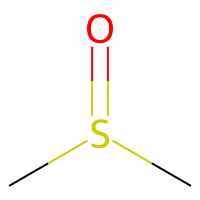
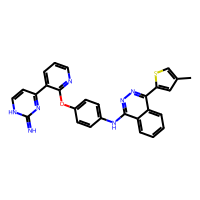
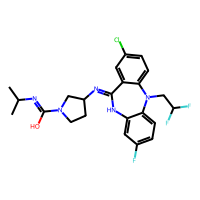
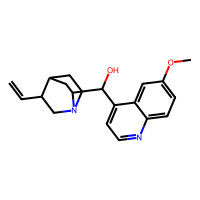
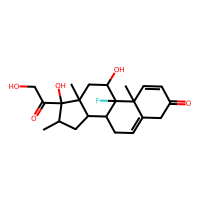
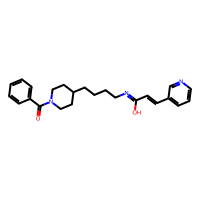
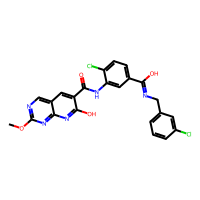
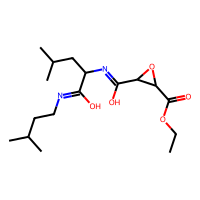
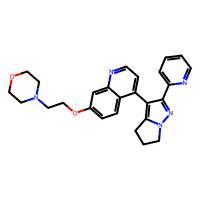
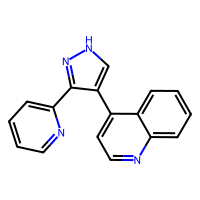

In [84]:
hi_counts

|A|B|
|---- |---- |
|CS(C)=O|tbd|
|
CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(=N)N=4)c6ccccc5|tbd|6|
CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c4ccc(Cl)cc|tbd|3|4
C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34|tbd|)|OC
CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O)C(=|tbd|O|)CO
OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3c|tbd|c|ccc3
COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)c2)c(O|tbd|)|nc3n4
CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=N|tbd|C|CC(C)C
C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5|tbd|c|6ccccn6
C1NN=C(C=1c2ccnc3ccccc23|tbd|)c4ccccn4

In [229]:
# for idx, val in compound_counts[compound_counts>60].items():
#     print(idx, '    ', df_compounds_indexed.loc[idx].smiles)
for row in counts_gt_60.itertuples():
    print(row.Index, '    ', row.smiles )

JCP2022_033924      CS(C)=O
JCP2022_037716      CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(=N)N=4)c6ccccc56
JCP2022_064022      CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c4ccc(Cl)cc34
JCP2022_050797      C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC
JCP2022_025848      CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O)C(=O)CO
JCP2022_046054      OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3
JCP2022_012818      COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)c2)c(O)nc3n4
JCP2022_085227      CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C
JCP2022_035095      C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6ccccn6
JCP2022_033954      C1NN=C(C=1c2ccnc3ccccc23)c4ccccn4


In [241]:
joined_metadata_2.info()
# joined_metadata_2.loc['JCP2022_033924'] 
joined_metadata_2[joined_metadata_2.Metadata_JCP2022 == 'JCP2022_033924'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793603 entries, 0 to 793602
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_Source    793603 non-null  object 
 1   Metadata_Batch     793603 non-null  object 
 2   Metadata_Plate     793603 non-null  object 
 3   Metadata_Well      793603 non-null  object 
 4   Metadata_JCP2022   793603 non-null  object 
 5   Metadata_InChIKey  793603 non-null  object 
 6   Metadata_InChI     793603 non-null  object 
 7   smiles             793603 non-null  object 
 8   TPSA               793603 non-null  float64
 9   lnTPSA             793603 non-null  float64
 10  log10TPSA          793603 non-null  float64
 11  permiation         793603 non-null  int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 72.7+ MB


,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
0,JCP2022_033924,source_1,Batch1_20221004,UL001641,A02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,JCP2022_033924,source_1,Batch1_20221004,UL001641,A04,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
2,JCP2022_033924,source_1,Batch1_20221004,UL001641,A45,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
3,JCP2022_033924,source_1,Batch1_20221004,UL001641,A47,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
4,JCP2022_033924,source_1,Batch1_20221004,UL001641,AA02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
...,...,...,...,...,...,...,...,...,...,...,...,...
88578,JCP2022_033924,source_9,20211103-Run16,GR00004421,Y47,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
88579,JCP2022_033924,source_9,20211103-Run16,GR00004421,Z02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
88580,JCP2022_033924,source_9,20211103-Run16,GR00004421,Z23,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
88581,JCP2022_033924,source_9,20211103-Run16,GR00004421,Z26,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


In [238]:
# del sampleb

In [247]:
# .groupby(by = ['Metadata_Source', 'Metadata_Plate']) 
grouped_metadata = joined_metadata.groupby(by = ['Metadata_Source', 'Metadata_Plate'])

In [293]:
len(grouped_metadata)
cur_key = ''
cur_ttl = 0 
for ctr, (keys, group_data) in enumerate(grouped_metadata):
    if cur_key != keys[0]:
        print(f"       Total for plates {cur_key} : {cur_ttl}")
        cur_key = keys[0]
        cur_ttl = 0
    # print(f"{ctr:5d}     {keys[0]}   {keys[1]}   {group_data.shape[0]}") 
    cur_ttl += 1
    
    # group_data.info()
    # group_data.memory_usage(deep=True)
    # if ctr > 500:
    #     break
print(f"       Total for plates {cur_key} : {cur_ttl}")
    

1731

       Total for plates  : 0
       Total for plates source_1 : 51
       Total for plates source_10 : 208
       Total for plates source_11 : 173
       Total for plates source_2 : 219
       Total for plates source_3 : 237
       Total for plates source_5 : 197
       Total for plates source_6 : 227
       Total for plates source_7 : 121
       Total for plates source_8 : 199
       Total for plates source_9 : 99


In [ ]:
JCP2022_033924      CS(C)=O
JCP2022_037716      CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(=N)N=4)c6ccccc56
JCP2022_064022      CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c4ccc(Cl)cc34
JCP2022_050797      C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC
JCP2022_025848      CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O)C(=O)CO
JCP2022_046054      OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3
JCP2022_012818      COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)c2)c(O)nc3n4
JCP2022_085227      CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C
JCP2022_035095      C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6ccccn6
JCP2022_033954      C1NN=C(C=1c2ccnc3ccccc23)c4ccccn4

In [375]:
CC = "JCP2022_033924"
# CC = "JCP2022_037716"
# CC = "JCP2022_064022"
# CC = "JCP2022_050797"
# CC = "JCP2022_025848"
# CC = "JCP2022_046054"
# CC = "JCP2022_012818"
# CC = "JCP2022_085227"
# CC = "JCP2022_035095"
# CC = "JCP2022_033954"
dmso_metadata = joined_metadata[joined_metadata.Metadata_JCP2022 == CC]
dmso_metadata.shape 

grouped_dmso = dmso_metadata.groupby(by = ['Metadata_Source', 'Metadata_Plate'])

print(CC)
cur_key = ''
cur_plate_ttl = 0 
cur_well_ttl = 0 
well_ttl = 0
plate_ttl = 0
ttls = {} 
for ctr, (keys, group_data) in enumerate(grouped_dmso):
    if cur_key != keys[0]:
        if cur_key != '' :
            print(f"       Total for plates from {cur_key:10s} :    {cur_plate_ttl:4d}  total wells: {cur_well_ttl:5d} ")
            ttls[int(cur_key.split('_')[-1])] = (cur_plate_ttl, cur_well_ttl)
        cur_key = keys[0]
        cur_plate_ttl = 0
        cur_well_ttl = 0
    # print(f"{ctr:5d}     {keys[0]}   {keys[1]}   {group_data.shape[0]}") 
    cur_plate_ttl += 1
    plate_ttl +=1
    cur_well_ttl  += group_data.shape[0]
    well_ttl+= group_data.shape[0]
    # group_data.info()
    # group_data.memory_usage(deep=True)
    # if ctr > 500:
    #     break

print(f"       Total for plates from {cur_key:10s} :    {cur_plate_ttl:4d}  total wells: {cur_well_ttl:5d} ")

ttls[int(cur_key.split('_')[-1])] = (cur_plate_ttl, cur_well_ttl)
print(f'\n\n {CC} \n')
for i in range(1,12): 
    a = ttls.get(i, (1, 0))
    print(f" source {i:2d}    {a[0]:5d}   {a[1]:5d}   {a[1]/a[0]:>10.1f}")

print(f"\n plates : {plate_ttl}    wells: {well_ttl}")

(88583, 12)

JCP2022_033924
       Total for plates from source_1   :      51  total wells:  9217 
       Total for plates from source_10  :     205  total wells:  6560 
       Total for plates from source_11  :     173  total wells:  7587 
       Total for plates from source_2   :     219  total wells: 10877 
       Total for plates from source_3   :     237  total wells:  7574 
       Total for plates from source_5   :     197  total wells:  6304 
       Total for plates from source_6   :     225  total wells: 12832 
       Total for plates from source_7   :     121  total wells:  7184 
       Total for plates from source_8   :     199  total wells:  7776 
       Total for plates from source_9   :      99  total wells: 12672 


 JCP2022_033924 

 source  1       51    9217        180.7
 source  2      219   10877         49.7
 source  3      237    7574         32.0
 source  4        1       0          0.0
 source  5      197    6304         32.0
 source  6      225   12832         57.0
 source  

#### Histogram

In [110]:
# import matplotlib.pyplot as plt
# the histogram of the data
# plt.figure(figsize=(9, 5))
# n, bins, patches = plt.hist(df_compound_counts[10:].values, range(1,60), density= False) ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
# n, bins, patches = plt.hist(df_well_use_counts, range(1,60), density= False) ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')

# print('n', n[:10])
# print('bins: ', bins[:10])
# plt.xlabel('Count')
# plt.ylabel('# of Wells')
# plt.title('Histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(0, 60)
# plt.ylim(0, 10000)
# plt.grid(True)
# plt.show()